# Notebook Davide, overview ed elenco punti da svolgere. 

In [1]:
# Libraries and functions
library(ggplot2)
#la libreria plyr serve per la funzione che ho definiyo sotto che torna utile per i plot
library(plyr)
summarySE <- function(data=NULL, measurevar, groupvars=NULL, na.rm=FALSE,
                      conf.interval=.95, .drop=TRUE) {
    library(plyr)

    # New version of length which can handle NA's: if na.rm==T, don't count them
    length2 <- function (x, na.rm=FALSE) {
        if (na.rm) sum(!is.na(x))
        else       length(x)
    }

    # This does the summary. For each group's data frame, return a vector with
    # N, mean, and sd
    datac <- ddply(data, groupvars, .drop=.drop,
      .fun = function(xx, col) {
        c(N    = length2(xx[[col]], na.rm=na.rm),
          mean = mean   (xx[[col]], na.rm=na.rm),
          sd   = sd     (xx[[col]], na.rm=na.rm)
        )
      },
      measurevar
    )

    # Rename the "mean" column    
    datac <- rename(datac, c("mean" = measurevar))

    datac$se <- datac$sd / sqrt(datac$N)  # Calculate standard error of the mean

    # Confidence interval multiplier for standard error
    # Calculate t-statistic for confidence interval: 
    # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
    ciMult <- qt(conf.interval/2 + .5, datac$N-1)
    datac$ci <- datac$se * ciMult

    return(datac)
}

Prima di tutto carico il dataset, ne eseguo un sample e ne osservo le colonne.
Obiettivi:
Ci si concentra sul numero medio di feriti e di vittime PER INCIDENTE in funzione di vari fattori. 
- Per prima cosa vengono mostrati due barplot in cui si osserva la frequenza del numero di vittime e del numero di feriti negli incidenti. 
    Si nota che in più del 90% dei casi di incidente grave registrati non ci sono vittime. Si osserva, inoltre, che la maggior pante degli incidenti hanno un solo ferito (sia moda che mediana).
    Si mostrano poi il numero medio di feriti e di vittime per incidente, con le relative deviazioni standard (non deviazione della media).
- Si analizzano poi le stesse quantità in funzione dei vari fattori. 
    Questi fattori sono:
    - Trimestre
    - Ora
    - Fondo stradale
    - Tipo di strada
    - Pavimentazione
    
La logica dei confronti è la seguente:
-> Prima viene mostrato un **barplot** la media di feriti e vittime con la relativa sd della media in funzione dei vari fattori (media e sd della media di feriti e vittime per ciascun fondo stradale, Ora, ecc..) 
-> In seguito si applica per ciascuna "classe" di fattori, separatamente per morti e feriti, **un test ANOVA ad una via**. Ossia un test d'ipotesi che ha come ipotesi nulla che tutte le medie siano uguali. 
   Se il test non è statisticamente significativo (confidence level del 95%), ci si ferma. Se il test invece è statisticamente significativo viene eseguito un **test della t di student fra tutte le classi**, che viene rappresentato in forma di tabella a doppia entrata. In questo modo si può tener conto dell'inflazione del p-value per confronti tra più classi, e si può osservare per quali classi si rifiuta l'ipotesi nulla (ossia che le medie siano uguali). 
   La logica dei test fatti è basata sulle ipotesi che: 
   -Gli incidenti sono eventi indipendenti aventi stessa distribuzione di probabilità
   -Il numero di vittime e di feriti è una variabile casuale discreta, similmente agli incidenti, si ipotizza che si tratti di variabili **iid**
Per questo motivo si sfrutta il teorema del limite centrale, che permette di applicare i test di ipotesi.
Non è possibile applicare test di ipotesi alle quantità in sè in quanto non sono distribuite secondo una normale.

In [2]:
dataset_proj <- read.csv("dataset/dataset progetto.csv", sep=';')
SAMPLE_SIZE = 20000
sample_rows <- sample(nrow(dataset_proj), SAMPLE_SIZE)
sample_data = dataset_proj[sample_rows,]
#names(sample_data)


## Sistemo leggermente le principali colonne del dataset.

In [3]:
attach(sample_data)
#giorno della settimana
giorno <- factor(giorno)
levels(giorno) <- c("Lun", "Mar", "Mer", "Gio", "Ven", "Sab", "Dom")

#pavimentazione
pavimentazione <- factor(pavimentazione)
levels(pavimentazione) <- c("good", "bad", "non-pav")

#fondo stradale
fondo_stradale <- factor(fondo_stradale)
levels(fondo_stradale) <- c("asciutto", "bagnato", "sdrucciolevole", "ghiacciato", "innevato")

#tipo di strada
tipo_di_strada <- factor(tipo_di_strada)
levels(tipo_di_strada) <- c("urbana", "extraurbana", "autostrada", "altro")

#trimestre
trimestre <- factor(trimestre)
levels(trimestre) <- c("Gen-Mar", "Apr-Giu", "Lug-Set", "Ott-Dic")

#creo una nuova colonna nel dataframe contenente la somma delle colonne "morti_entro_24_ore", "morti_entro_30_giorni"
sample_data$morti = morti_entro_24_ore + morti_entro_30_giorni

#tipo di veicolo, divido tutto in macchina, moto, veicolo pesante
reset_veicolo <- function(val){
    if (is.na(val)){
        #manca il valore, pongo 0
        return(0)
    }
    if (val <= 4){
        #è una macchina
        return(1)
    }
    if (val > 4 && val <= 13){
        #è un mezzo pesante
        return(2)
    }
    if (val > 4){
        #è una moto/veicolo a 2 ruote
        return(3)
    }
}

coinvolta_moto <- function(val1, val2, val3){
    if (val1 == 3 || val2 == 3 || val3 == 3){
        return(1)
    }else{
        return(0)
    }
} 

coinvolta_auto <- function(val1, val2, val3){
    if (val1 == 1 || val2 == 1 || val3 == 1){
        return(1)
    }else{
        return(0)
    }
}

coinvolto_mezzo <- function(val1, val2, val3){
    if (val1 == 2 || val2 == 2 || val3 == 2){
        return(1)
    }else{
        return(0)
    }
}

presenza_morti <- function(val){
    if (val == 0){
        return(0)
    }else{
        return(1)
    }
}

for (i in c(1:nrow(sample_data))){
    sample_data$veicolo_a[i] = reset_veicolo(tipo_veicolo_a[i])
    sample_data$veicolo_b[i] = reset_veicolo(tipo_veicoli__b_[i])
    sample_data$veicolo_c[i] = reset_veicolo(tipo_veicolo__c_[i])
    sample_data$presenza_morti[i] = presenza_morti(sample_data$morti[i])
    sample_data$coinvolta_moto[i] = coinvolta_moto(sample_data$veicolo_a[i], sample_data$veicolo_b[i], sample_data$veicolo_c[i])
    sample_data$coinvolta_auto[i] = coinvolta_auto(sample_data$veicolo_a[i], sample_data$veicolo_b[i], sample_data$veicolo_c[i])
    sample_data$coinvolto_mezzo[i] = coinvolto_mezzo(sample_data$veicolo_a[i], sample_data$veicolo_b[i], sample_data$veicolo_c[i])
}
sample_data$veicolo_a <- factor(sample_data$veicolo_a)
sample_data$veicolo_b <- factor(sample_data$veicolo_b)
sample_data$veicolo_c <- factor(sample_data$veicolo_c)
levels(sample_data$veicolo_a) <- c("Auto", "Mezzo pesante", "Motociclo")
levels(sample_data$veicolo_b) <- c("Sconosciuto", "Auto", "Mezzo pesante", "Motociclo")
levels(sample_data$veicolo_c) <- c("Sconosciuto", "Auto", "Mezzo pesante", "Motociclo")

In [4]:
#visualizzo il dataset
head(sample_data)

,anno,provincia,comune,giorno,organo_di_rilevazione,localizzazione_incidente,denominazione_della_strada,tronco_di_strada_o_autostrada,tipo_di_strada,pavimentazione,⋯,ettometrica,trimestre,morti,veicolo_a,veicolo_b,veicolo_c,presenza_morti,coinvolta_moto,coinvolta_auto,coinvolto_mezzo
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<int>,<int>,⋯,<fct>,<int>,<int>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
116257,17,23,17,5,4,1,0,12,2,1,⋯,0,3,0,Auto,Sconosciuto,Sconosciuto,0,0,1,0
70934,17,30,122,6,2,5,13,12,2,1,⋯,0,4,0,Auto,Motociclo,Sconosciuto,0,1,1,0
36576,17,12,42,6,2,1,0,12,3,1,⋯,0,2,0,Auto,Auto,Sconosciuto,0,0,1,0
7190,17,54,39,4,1,6,3,3,3,1,⋯,100,2,0,Mezzo pesante,Mezzo pesante,Mezzo pesante,0,0,0,1
7431,17,56,36,1,1,1,0,12,2,1,⋯,0,3,0,Motociclo,Auto,Sconosciuto,0,1,1,0
136922,17,36,23,4,4,1,0,12,2,1,⋯,0,3,0,Auto,Motociclo,Sconosciuto,0,1,1,0


## Un po' di statistica univariata

### Numero medio di feriti e morti per incidente grave

In [5]:
#calcolo media e deviazione standard di feriti e morti per incidente stradale 
MEAN_INJ = mean(sample_data$feriti)
SD_INJ = sd(sample_data$feriti)
MEAN_DEA = mean(sample_data$morti)
SD_DEA = sd(sample_data$morti)
cat("Nel 2017 la media di feriti per incidente è stata: ", MEAN_INJ, "+-", SD_INJ, "\n")
cat("Nel 2017 la media di feriti per incidente è stata: ", MEAN_DEA, "+-", SD_DEA)

Nel 2017 la media di feriti per incidente è stata:  1.4098 +- 0.878466 
Nel 2017 la media di feriti per incidente è stata:  0.0199 +- 0.15035

**Annotazioni**: non disponendo della data dei singoli incidenti non si è in grado di fornire un indice di variabilità della misura.

### Plotto le frequenze relative del numero di morti e feriti per incidente stradale

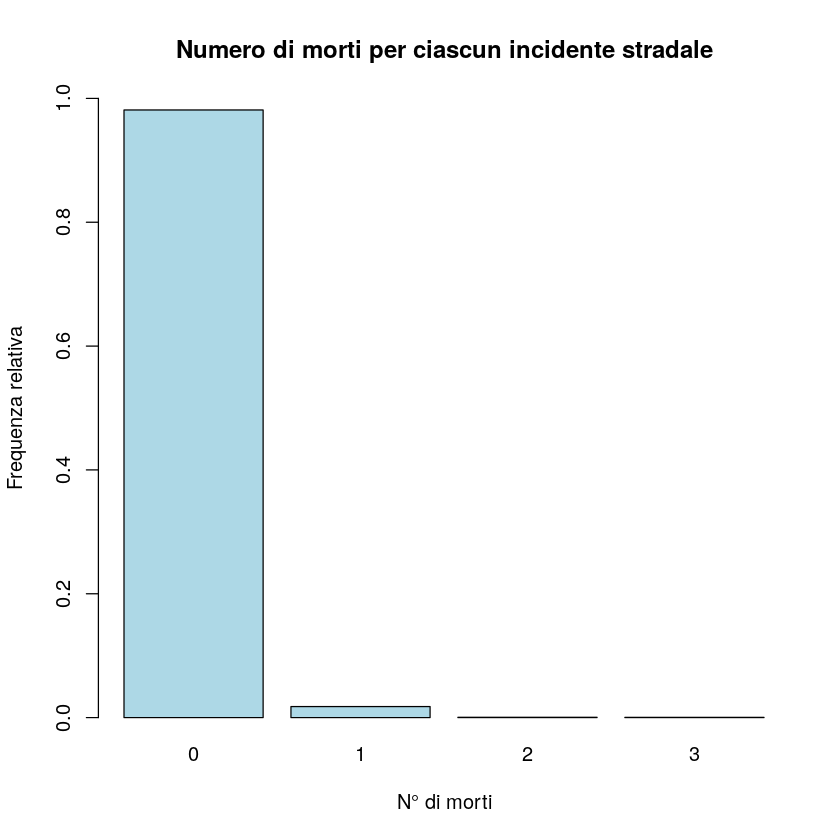

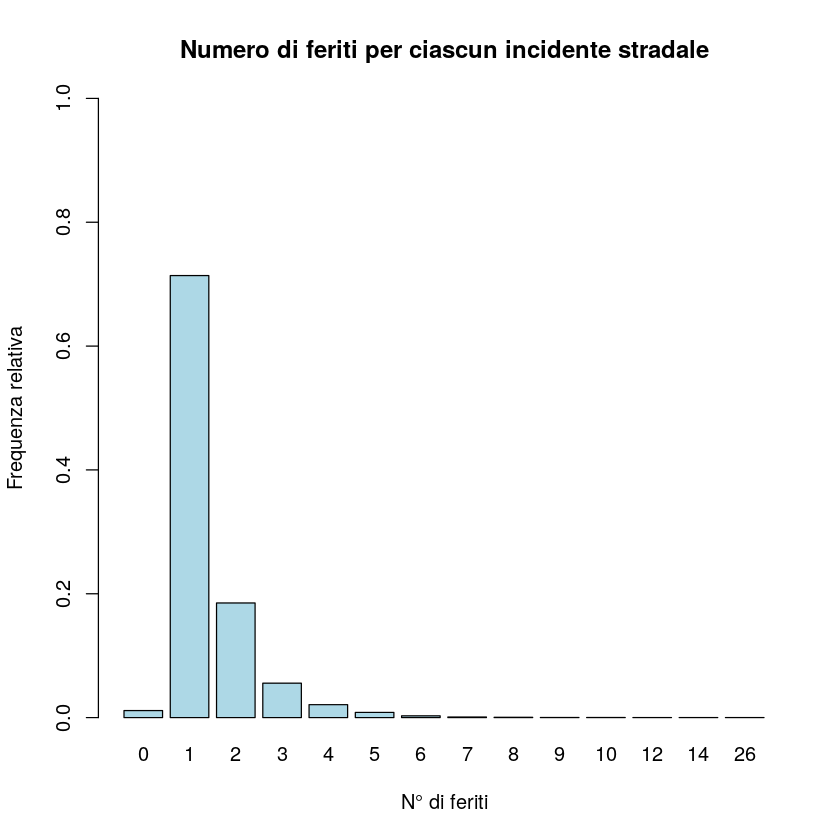

In [6]:
#morti
DEATHS_TABLE = table(sample_data$morti)
barplot(DEATHS_TABLE/nrow(sample_data), 
        main = "Numero di morti per ciascun incidente stradale", 
        xlab = "N° di morti", 
        ylab = "Frequenza relativa", 
        ylim=c(0,1), 
        col = "lightblue"
       )
#feriti
INJ_TABLE = table(sample_data$feriti)
barplot(INJ_TABLE/nrow(sample_data), 
        main = "Numero di feriti per ciascun incidente stradale", 
        xlab = "N° di feriti", 
        ylab = "Frequenza relativa", 
        ylim=c(0,1), 
        col = "lightblue"
       )

### Numero di iferiti e morti diviso per trimestre e ora del giorno

In [7]:
#CI SONO DEI NAN CHE NON HO IDEA DA DOVE VENGANO E LI HO LEVATI
MEAN_INJ_TRIM = summarySE(sample_data, measurevar = "feriti", groupvars = c("trimestre"), na.rm = TRUE, .drop = TRUE)
MEAN_INJ_TRIM = MEAN_INJ_TRIM[complete.cases(MEAN_INJ_TRIM), ]
MEAN_DEA_TRIM = summarySE(sample_data, measurevar = "morti", groupvars = c("trimestre"), na.rm = TRUE, .drop = TRUE)
MEAN_DEA_TRIM = MEAN_DEA_TRIM[complete.cases(MEAN_DEA_TRIM), ]

#rimuovo le righe dove l'orario non è noto
MEAN_INJ_HOUR = summarySE(sample_data[Ora != 25,], measurevar = "feriti", groupvars = c("Ora"), na.rm = FALSE, .drop = TRUE)
MEAN_DEA_HOUR = summarySE(sample_data[Ora != 25,], measurevar = "morti", groupvars = c("Ora"), na.rm = FALSE, .drop = TRUE)

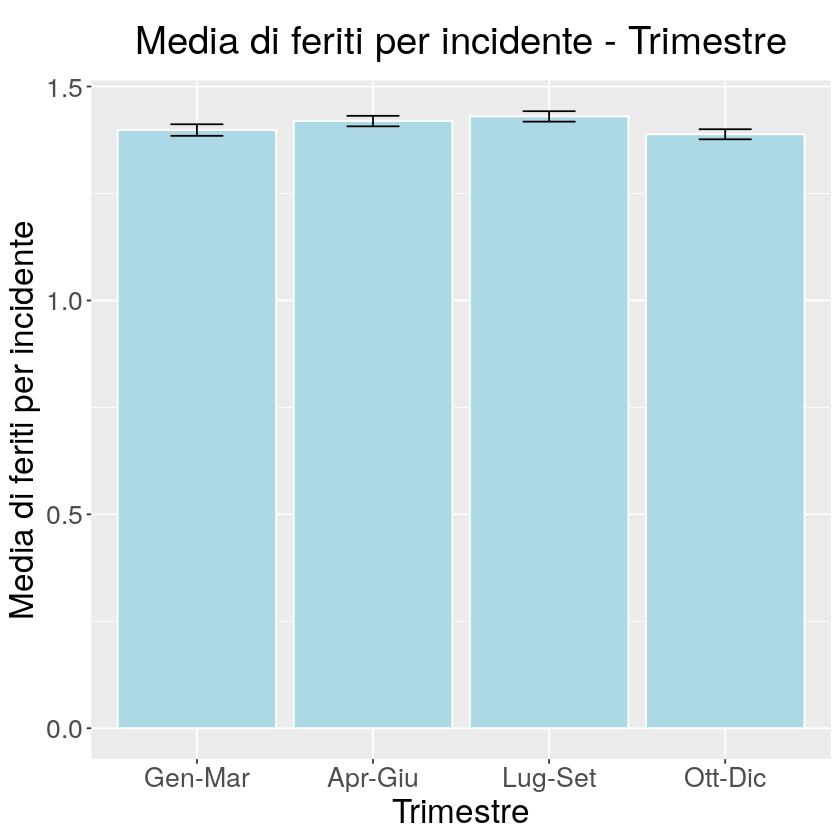

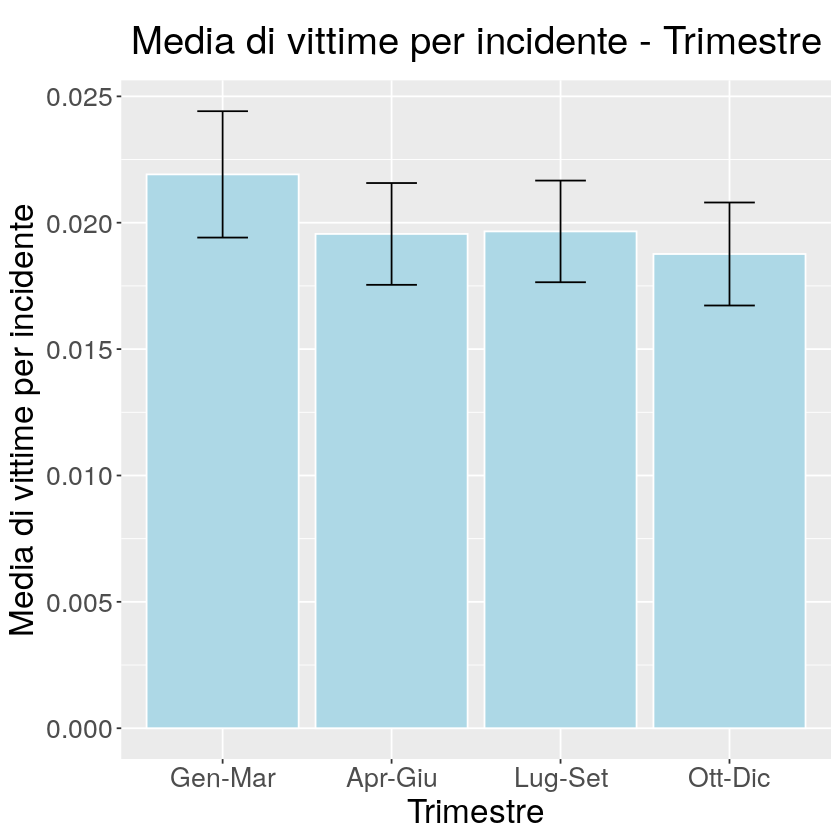

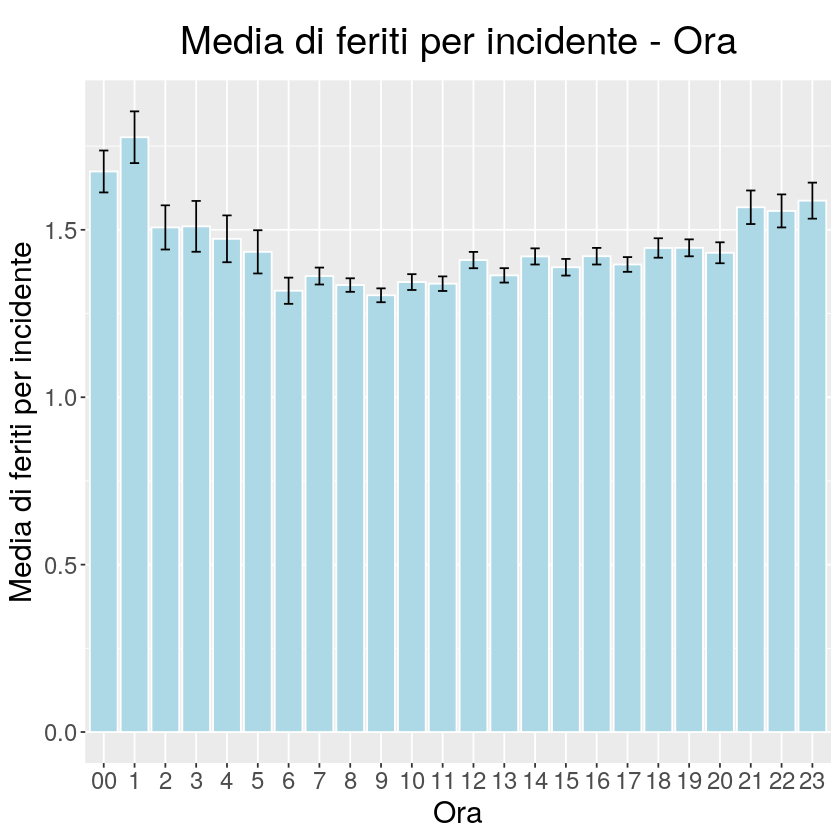

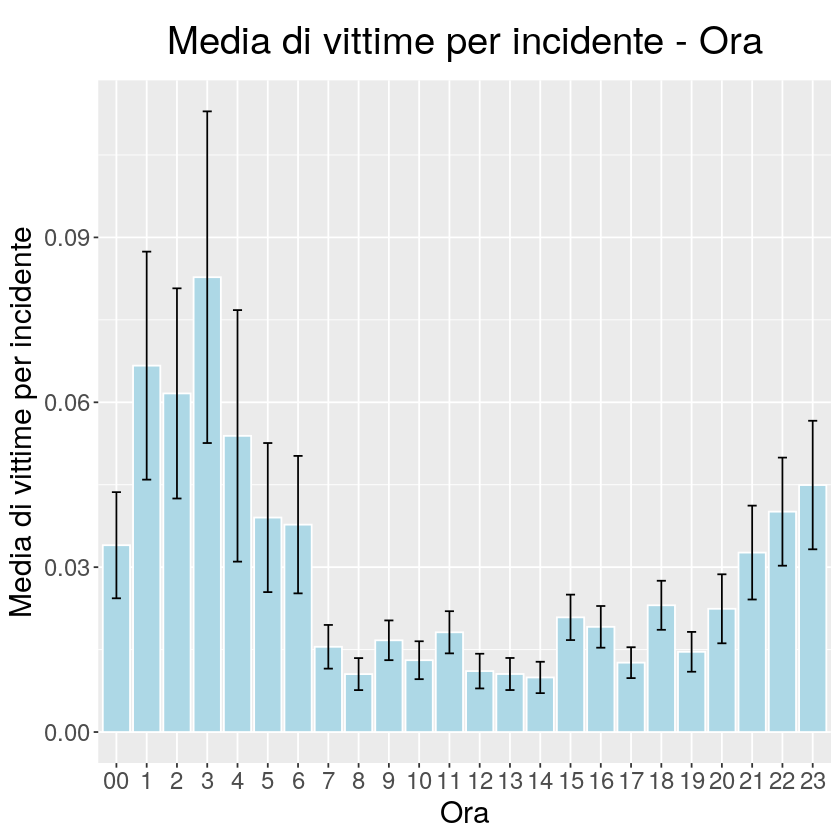

In [8]:
#plotto i risultati - per trimestre
#prima i feriti
MEAN_INJ_TRIM$trimestre <- factor(MEAN_INJ_TRIM$trimestre)
levels(MEAN_INJ_TRIM$trimestre) <- c("Gen-Mar", "Apr-Giu", "Lug-Set", "Ott-Dic")
bar_inj_trim <- ggplot(MEAN_INJ_TRIM, aes(x=trimestre, y=feriti)) + 
                geom_bar(position=position_dodge(), stat="identity", color="white", fill="lightblue") +
                geom_errorbar(aes(ymin=feriti-se, ymax=feriti+se),
                              width=.3,                    # Width of the error bars
                              position=position_dodge(.9)
                             ) + 
                labs(
                    title = "Media di feriti per incidente - Trimestre",
                    x = "Trimestre",
                    y = "Media di feriti per incidente"
                   ) + 
                theme(
                     text = element_text(size=20), 
                     plot.title = element_text(size = 23, vjust = 1, margin = margin(10,0,10,0), hjust = 0.5),
                    )

#poi i morti
MEAN_DEA_TRIM$trimestre <- factor(MEAN_DEA_TRIM$trimestre)
levels(MEAN_DEA_TRIM$trimestre) <- c("Gen-Mar", "Apr-Giu", "Lug-Set", "Ott-Dic")
bar_dea_trim <- ggplot(MEAN_DEA_TRIM, aes(x=trimestre, y=morti)) + 
                geom_bar(position=position_dodge(), stat="identity", color="white", fill="lightblue") +
                geom_errorbar(aes(ymin=morti-se, ymax=morti+se),
                              width=.3,                    # Width of the error bars
                              position=position_dodge(.9)
                             ) +
                labs(
                    title = "Media di vittime per incidente - Trimestre",
                    x = "Trimestre",
                    y = "Media di vittime per incidente"
                   ) + 
                theme(
                     text = element_text(size=20), 
                     plot.title = element_text(size = 23, vjust = 1, margin = margin(10,0,10,0), hjust = 0.5),
                    )



#plotto i risultati - per ora


#prima i feriti
MEAN_INJ_HOUR$Ora <- factor(MEAN_INJ_HOUR$Ora)
levels(MEAN_INJ_HOUR$Ora) <- c("00","1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22","23")
bar_inj_hour <- ggplot(MEAN_INJ_HOUR, aes(x=Ora, y=feriti)) + 
                geom_bar(position=position_dodge(), stat="identity", color="white", fill="lightblue") +
                geom_errorbar(aes(ymin=feriti-se, ymax=feriti+se),
                              width=.3,                    # Width of the error bars
                              position=position_dodge(.9)
                             ) + 
                labs(
                    title = "Media di feriti per incidente - Ora",
                    x = "Ora",
                    y = "Media di feriti per incidente"
                   ) + 
                theme(
                     text = element_text(size=18), 
                     plot.title = element_text(size = 23, vjust = 1, margin = margin(10,0,10,0), hjust = 0.5),
                    )


#poi i morti
MEAN_DEA_HOUR$Ora <- factor(MEAN_DEA_HOUR$Ora)
levels(MEAN_DEA_HOUR$Ora) <- c("00","1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22","23")
bar_dea_hour <- ggplot(MEAN_DEA_HOUR, aes(x=Ora, y=morti)) + 
                geom_bar(position=position_dodge(), stat="identity", color="white", fill="lightblue") +
                geom_errorbar(aes(ymin=morti-se, ymax=morti+se),
                              width=.3,                    # Width of the error bars
                              position=position_dodge(.9)
                             ) + 
                labs(
                    title = "Media di vittime per incidente - Ora",
                    x = "Ora",
                    y = "Media di vittime per incidente"
                   ) + 
                theme(
                     text = element_text(size=18), 
                     plot.title = element_text(size = 23, vjust = 1, margin = margin(10,0,10,0), hjust = 0.5),
                    )


#-------------PLOTS--------------------
bar_inj_trim  
bar_dea_trim
bar_inj_hour
bar_dea_hour

### Test d'ipotesi, in ciascun trimestre, il numero di incidenti al giorno è lo stesso

In [9]:
#test anova ad una via per l'uguaglianza delle medie
test_inj_trim <- oneway.test(feriti ~ trimestre, data = sample_data)
test_dea_trim <- oneway.test(morti ~ trimestre, data = sample_data)
test_inj_hour <- oneway.test(feriti ~ Ora, data = sample_data[Ora != 25,])
test_dea_hour <- oneway.test(morti ~ Ora, data = sample_data[Ora != 25,])
test_inj_trim
test_dea_trim
test_inj_hour
cat("\n \n Nel caso dei feriti, il test è statisticamente significativo - Eseguo un t-test fra tutte le coppie")
test_coppie_ora_inj <- pairwise.t.test(sample_data[Ora != 25,]$feriti, sample_data[Ora != 25,]$Ora)
test_coppie_ora_inj
test_dea_hour
cat("\n \n Nel caso dei morti, il test è statisticamente significativo - Eseguo un t-test fra tutte le coppie")
test_coppie_ora_dea <- pairwise.t.test(sample_data[Ora != 25,]$morti, sample_data[Ora != 25,]$Ora)
test_coppie_ora_dea


	One-way analysis of means (not assuming equal variances)

data:  feriti and trimestre
F = 2.456, num df = 3, denom df = 10983, p-value = 0.06111



	One-way analysis of means (not assuming equal variances)

data:  morti and trimestre
F = 0.33103, num df = 3, denom df = 10910, p-value = 0.8029



	One-way analysis of means (not assuming equal variances)

data:  feriti and Ora
F = 6.2544, num df = 23.0, denom df = 3898.3, p-value < 2.2e-16



 
 Nel caso dei feriti, il test è statisticamente significativo - Eseguo un t-test fra tutte le coppie


	Pairwise comparisons using t tests with pooled SD 

data:  sample_data[Ora != 25, ]$feriti and sample_data[Ora != 25, ]$Ora 

   1       2       3       4       5       6       7       8       9      
2  1.00000 -       -       -       -       -       -       -       -      
3  1.00000 0.20123 -       -       -       -       -       -       -      
4  1.00000 0.67591 1.00000 -       -       -       -       -       -      
5  1.00000 0.10853 1.00000 1.00000 -       -       -       -       -      
6  0.36126 0.00705 1.00000 1.00000 1.00000 -       -       -       -      
7  1.1e-05 3.3e-08 1.00000 1.00000 1.00000 1.00000 -       -       -      
8  2.5e-06 4.8e-09 1.00000 1.00000 1.00000 1.00000 1.00000 -       -      
9  3.7e-08 6.4e-11 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 -      
10 6.5e-10 1.2e-12 0.37339 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000
11 1.1e-07 2.0e-10 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000
12 6.6e-08 1.2e-10 1.00000 1.00000 1.00000 1.00


	One-way analysis of means (not assuming equal variances)

data:  morti and Ora
F = 2.8837, num df = 23.0, denom df = 3867.9, p-value = 5.062e-06



 
 Nel caso dei morti, il test è statisticamente significativo - Eseguo un t-test fra tutte le coppie


	Pairwise comparisons using t tests with pooled SD 

data:  sample_data[Ora != 25, ]$morti and sample_data[Ora != 25, ]$Ora 

   1       2       3       4       5       6       7       8       9      
2  1.00000 -       -       -       -       -       -       -       -      
3  1.00000 1.00000 -       -       -       -       -       -       -      
4  0.20801 1.00000 1.00000 -       -       -       -       -       -      
5  1.00000 1.00000 1.00000 1.00000 -       -       -       -       -      
6  1.00000 1.00000 1.00000 1.00000 1.00000 -       -       -       -      
7  1.00000 1.00000 1.00000 0.44791 1.00000 1.00000 -       -       -      
8  1.00000 0.00032 0.01230 0.00012 0.45850 1.00000 1.00000 -       -      
9  1.00000 1.4e-05 0.00119 1.1e-05 0.10204 1.00000 0.45068 1.00000 -      
10 1.00000 0.00031 0.01330 0.00013 0.52503 1.00000 1.00000 1.00000 1.00000
11 1.00000 5.3e-05 0.00337 3.1e-05 0.20670 1.00000 1.00000 1.00000 1.00000
12 1.00000 0.00066 0.02395 0.00024 0.75947 1.000

### Analisi fondo stradale - vedo se esiste una correlazione fra il numero di morti per incidente e il tipo di fondo stradale

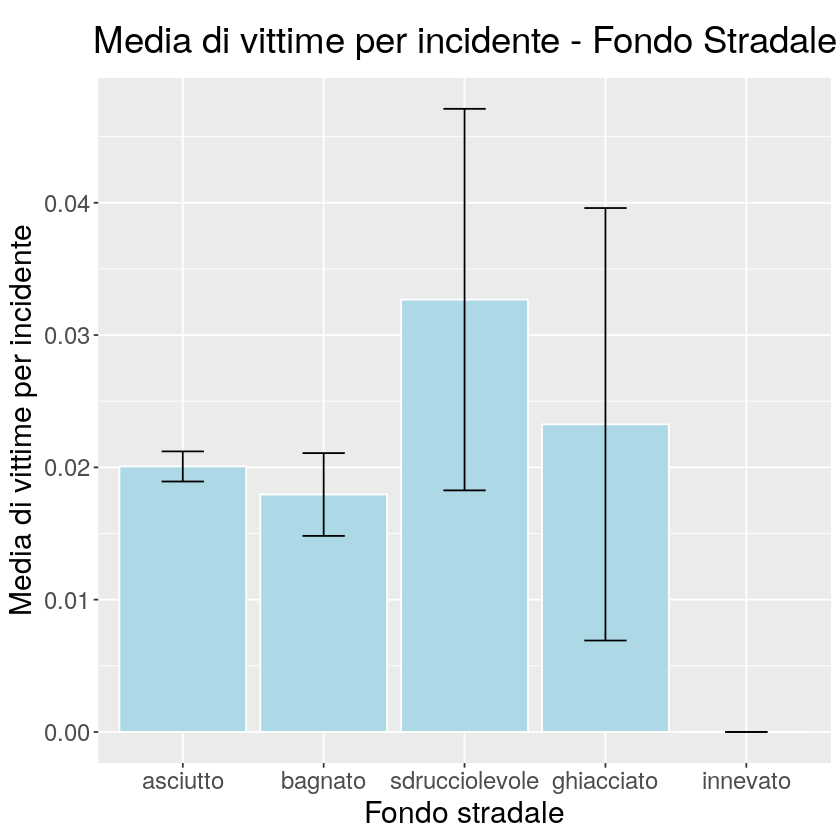


	One-way analysis of means (not assuming equal variances)

data:  morti and fondo_stradale
F = 0.41087, num df = 3.00, denom df = 270.27, p-value = 0.7453


Nel caso dei morti, il test non è statisticamente significativo - Mi fermo qui


	One-way analysis of means (not assuming equal variances)

data:  feriti and fondo_stradale
F = 4.1502, num df = 4.00, denom df = 129.46, p-value = 0.003391



 
 Nel caso dei feriti, il test è statisticamente significativo - Eseguo un t-test fra tutte le coppie


	Pairwise comparisons using t tests with pooled SD 

data:  feriti and fondo_stradale 

               asciutto bagnato sdrucciolevole ghiacciato
bagnato        0.5162   -       -              -         
sdrucciolevole 0.1594   0.1059  -              -         
ghiacciato     0.5162   0.5162  0.1403         -         
innevato       0.0189   0.0283  0.0026         0.1594    

P value adjustment method: holm 

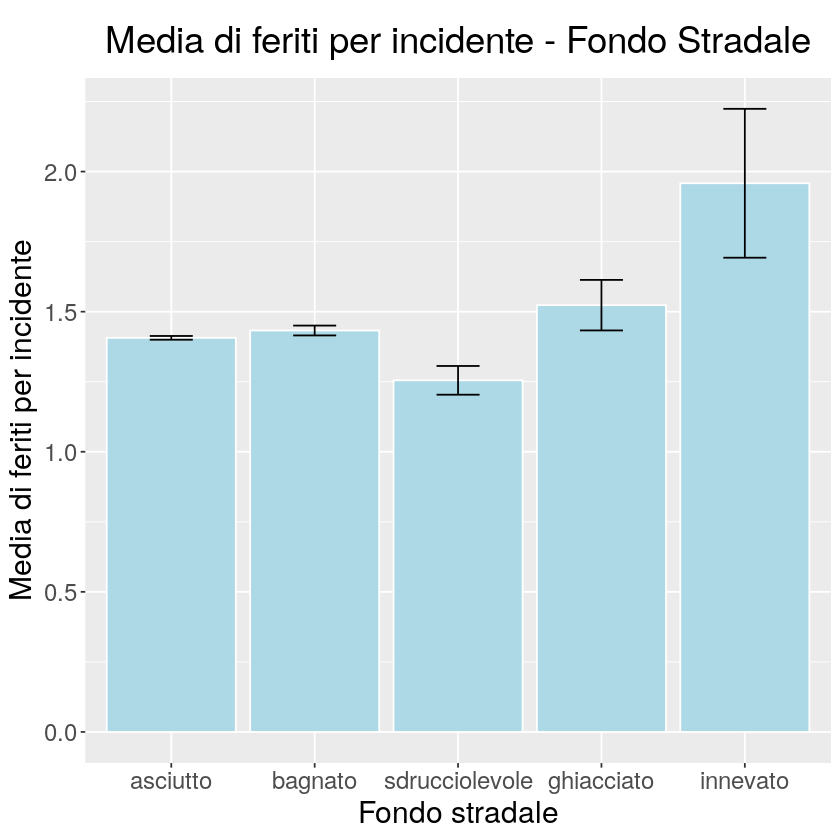

In [10]:
#comandi per il plot - morti
SUM_FONDO = summarySE(sample_data, measurevar = "morti", groupvars = c("fondo_stradale"))
SUM_FONDO$fondo_stradale <- factor(SUM_FONDO$fondo_stradale)
levels(SUM_FONDO$fondo_stradale) <- c("asciutto", "bagnato", "sdrucciolevole", "ghiacciato", "innevato")
bar_inj_fondo <- ggplot(SUM_FONDO, aes(x=fondo_stradale, y=morti)) + 
                 geom_bar(position=position_dodge(), stat="identity", color="white", fill="lightblue") +
                 geom_errorbar(aes(ymin=morti-se, ymax=morti+se),
                               width=.3,                    # Width of the error bars
                               position=position_dodge(.9)
                              ) +
                 labs(
                        title = "Media di vittime per incidente - Fondo Stradale",
                        x = "Fondo stradale",
                        y = "Media di vittime per incidente"
                    ) + 
                 theme(
                        text = element_text(size=18), 
                        plot.title = element_text(size = 22, vjust = 1, margin = margin(10,0,10,0), hjust = 0.5),
                    )


#test - morti
#escludo il suolo innevato per mancanza di dati
sample_data_no_snow = sample_data[fondo_stradale != "innevato",]
test_fondo_morti <- oneway.test(morti ~ fondo_stradale, data = sample_data_no_snow)


#comandi per il plot - feriti
SUM_FONDO_INJ = summarySE(sample_data, measurevar = "feriti", groupvars = c("fondo_stradale"))
SUM_FONDO_INJ$fondo_stradale <- factor(SUM_FONDO_INJ$fondo_stradale)
levels(SUM_FONDO_INJ$fondo_stradale) <- c("asciutto", "bagnato", "sdrucciolevole", "ghiacciato", "innevato")
bar_dea_fondo <- ggplot(SUM_FONDO_INJ, aes(x=fondo_stradale, y=feriti)) + 
                 geom_bar(position=position_dodge(), stat="identity", color="white", fill="lightblue") +
                 geom_errorbar(aes(ymin=feriti-se, ymax=feriti+se),
                          width=.3,                    # Width of the error bars
                          position=position_dodge(.9)
                         ) + 
                 labs(
                        title = "Media di feriti per incidente - Fondo Stradale",
                        x = "Fondo stradale",
                        y = "Media di feriti per incidente"
                    ) + 
                 theme(
                        text = element_text(size=18), 
                        plot.title = element_text(size = 22, vjust = 1, margin = margin(10,0,10,0), hjust = 0.5),
                    )



#test - feriti
test_fondo_feriti <- oneway.test(feriti ~ fondo_stradale, data = sample_data)
test_coppie_fondo_feriti <- pairwise.t.test(feriti, fondo_stradale)


#------------------PLOTS--------------------
bar_inj_fondo
bar_dea_fondo

#------------------test---------------------
test_fondo_morti
cat("Nel caso dei morti, il test non è statisticamente significativo - Mi fermo qui")

test_fondo_feriti
cat("\n \n Nel caso dei feriti, il test è statisticamente significativo - Eseguo un t-test fra tutte le coppie")
test_coppie_fondo_feriti

### La mortalità degli incidenti non dipende dal tipo di strada -> Vedi sopra

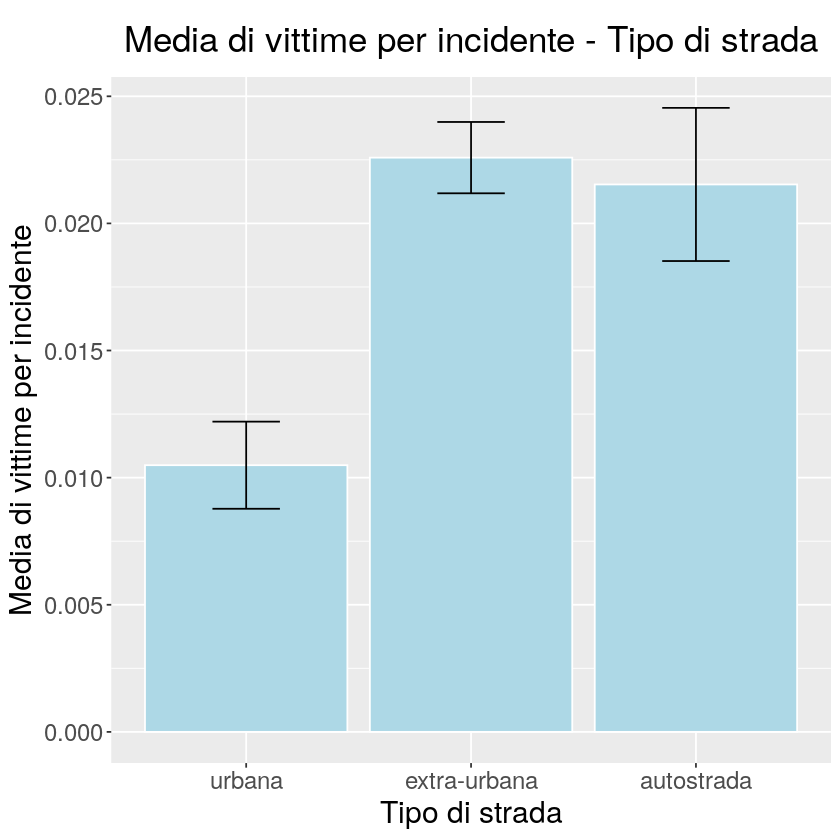


	One-way analysis of means (not assuming equal variances)

data:  morti and tipo_di_strada
F = 15.619, num df = 2.0, denom df = 5888.9, p-value = 1.716e-07



 
 Nel caso dei morti, il test è statisticamente significativo - Eseguo un t-test fra tutte le coppie


	Pairwise comparisons using t tests with pooled SD 

data:  sample_data_filt$morti and sample_data_filt$tipo_di_strada 

  1       2   
2 4.9e-05 -   
3 0.01    0.75

P value adjustment method: holm 


	One-way analysis of means (not assuming equal variances)

data:  feriti and tipo_di_strada
F = 19.812, num df = 2.0, denom df = 5111.4, p-value = 2.684e-09



 
 Nel caso dei feriti, il test è statisticamente significativo - Eseguo un t-test fra tutte le coppie


	Pairwise comparisons using t tests with pooled SD 

data:  sample_data_filt$feriti and sample_data_filt$tipo_di_strada 

  1       2      
2 0.0052  -      
3 7.5e-11 5.8e-08

P value adjustment method: holm 

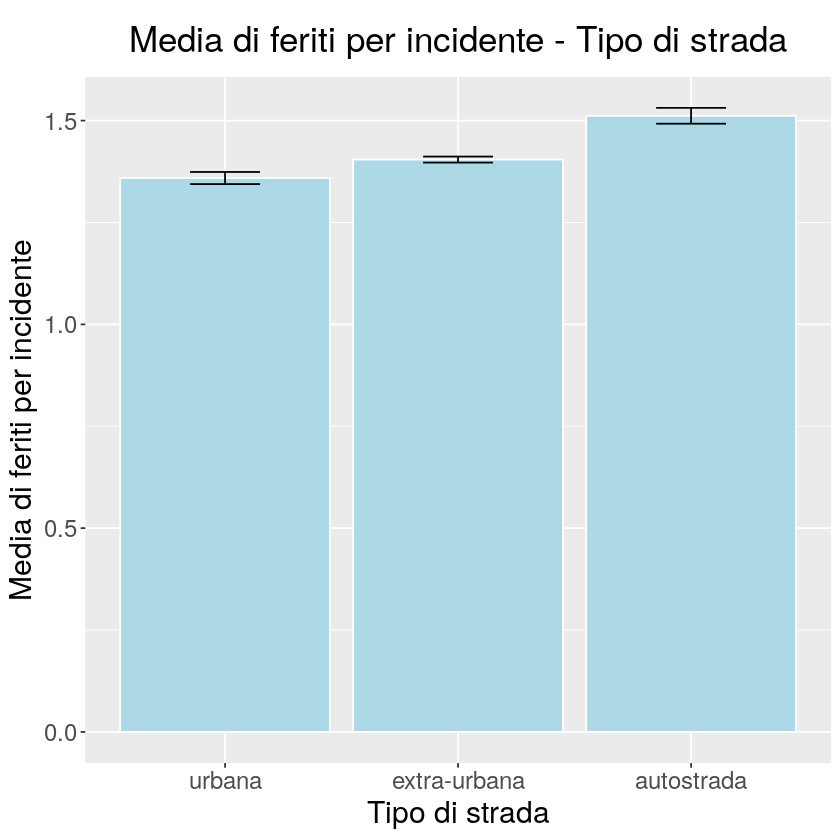

In [11]:
#escludo le righe dove non è noto il tipo di strada
sample_data_filt = sample_data[tipo_di_strada != "altro",]

#comandi per il plot - morti
SUM_STRADA = summarySE(sample_data_filt, measurevar = "morti", groupvars = c("tipo_di_strada"))
SUM_STRADA$tipo_di_strada <- factor(SUM_STRADA$tipo_di_strada)
levels(SUM_STRADA$tipo_di_strada) <- c("urbana", "extra-urbana", "autostrada")
bar_dea_strada <- ggplot(SUM_STRADA, aes(x=tipo_di_strada, y=morti)) + 
              geom_bar(position=position_dodge(), stat="identity", color="white", fill="lightblue") +
              geom_errorbar(aes(ymin=morti-se, ymax=morti+se),
                            width=.3,                    # Width of the error bars
                            position=position_dodge(.9)
                           ) + 
              labs(
                    title = "Media di vittime per incidente - Tipo di strada",
                    x = "Tipo di strada",
                    y = "Media di vittime per incidente"
                   ) + 
              theme(
                    text = element_text(size=18), 
                    plot.title = element_text(size = 21, vjust = 1, margin = margin(10,0,10,0), hjust = 0.5),
                    )


#test - morti
test_strada_morti <- oneway.test(morti ~ tipo_di_strada, data = sample_data_filt)
test_coppie_strada_morti <- pairwise.t.test(sample_data_filt$morti, sample_data_filt$tipo_di_strada)


#comandi per il plot - feriti
SUM_STRADA = summarySE(sample_data_filt, measurevar = "feriti", groupvars = c("tipo_di_strada"))
SUM_STRADA$tipo_di_strada <- factor(SUM_STRADA$tipo_di_strada)
levels(SUM_STRADA$tipo_di_strada) <- c("urbana", "extra-urbana", "autostrada")
bar_inj_strada <- ggplot(SUM_STRADA, aes(x=tipo_di_strada, y=feriti)) + 
                  geom_bar(position=position_dodge(), stat="identity", color="white", fill="lightblue") +
                  geom_errorbar(aes(ymin=feriti-se, ymax=feriti+se),
                                width=.3,                    # Width of the error bars
                                position=position_dodge(.9)
                               ) + 
                  labs(
                        title = "Media di feriti per incidente - Tipo di strada",
                        x = "Tipo di strada",
                        y = "Media di feriti per incidente"
                       ) + 
                  theme(
                        text = element_text(size=18), 
                        plot.title = element_text(size = 21, vjust = 1, margin = margin(10,0,10,0), hjust = 0.5),
                        )


#test - feriti
test_strada_feriti <- oneway.test(feriti ~ tipo_di_strada, data = sample_data_filt)
test_coppie_strada_feriti <- pairwise.t.test(sample_data_filt$feriti, sample_data_filt$tipo_di_strada)


#-------------------PLOT--------------
bar_dea_strada
bar_inj_strada

#-------------------TEST--------------
test_strada_morti
cat("\n \n Nel caso dei morti, il test è statisticamente significativo - Eseguo un t-test fra tutte le coppie")
test_coppie_strada_morti

test_strada_feriti
cat("\n \n Nel caso dei feriti, il test è statisticamente significativo - Eseguo un t-test fra tutte le coppie")
test_coppie_strada_feriti

### La mortalità degli incidenti non dipende dal tipo di pavimentazione -> Vedi sopra


	One-way analysis of means (not assuming equal variances)

data:  morti and pavimentazione
F = 2.298, num df = 2.000, denom df = 98.168, p-value = 0.1058


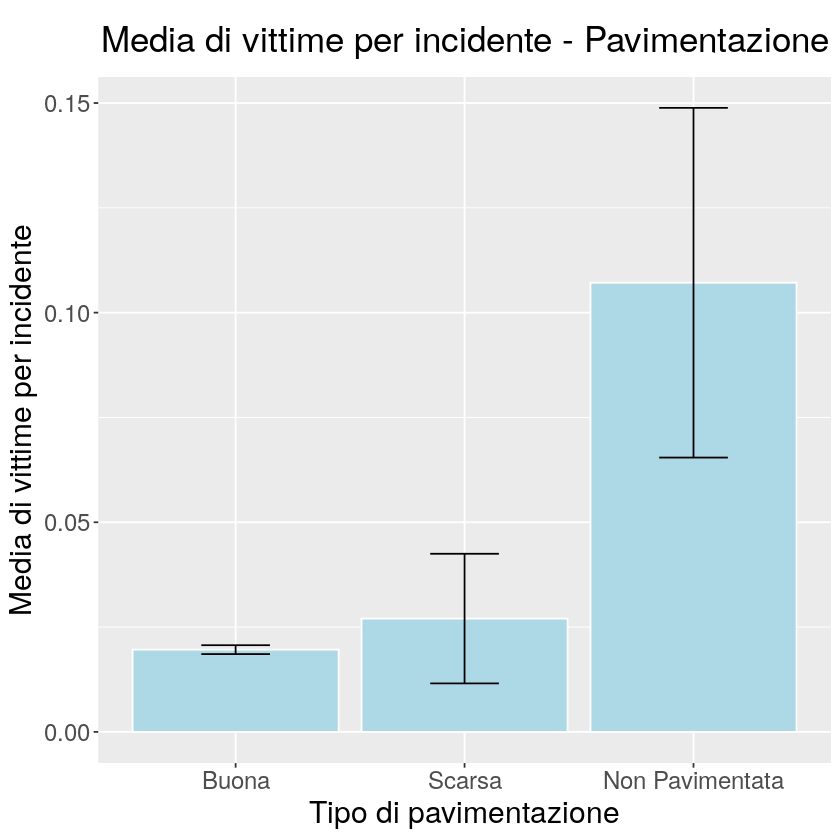


	One-way analysis of means (not assuming equal variances)

data:  feriti and pavimentazione
F = 4.4458, num df = 2.000, denom df = 98.907, p-value = 0.01416



 
 Nel caso dei feriti, il test è statisticamente significativo - Eseguo un t-test fra tutte le coppie


	Pairwise comparisons using t tests with pooled SD 

data:  sample_data$feriti and sample_data$pavimentazione 

  1    2   
2 0.78 -   
3 0.10 0.23

P value adjustment method: holm 

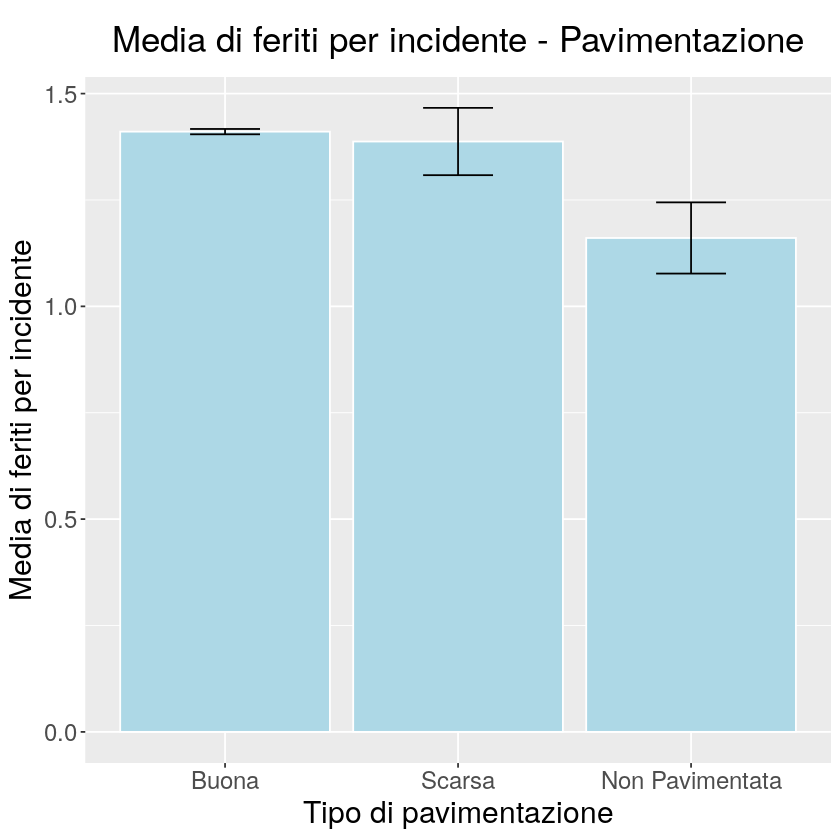

In [15]:
#escludo le righe dove non è noto il tipo di strada
#sample_data_filt = sample_data[tipo_di_strada != "altro",]

#comandi per il plot - morti
SUM_PAV = summarySE(sample_data, measurevar = "morti", groupvars = c("pavimentazione"))
SUM_PAV$pavimentazione <- factor(SUM_PAV$pavimentazione)
levels(SUM_PAV$pavimentazione) <- c("Buona", "Scarsa", "Non Pavimentata")
bar_pavimentazione_morti <- ggplot(SUM_PAV, aes(x=pavimentazione, y=morti)) + 
                            geom_bar(position=position_dodge(), stat="identity", color="white", fill="lightblue") +
                            geom_errorbar(aes(ymin=morti-se, ymax=morti+se),
                          width=.3,                    # Width of the error bars
                          position=position_dodge(.9)) + 
                            labs(
                            title = "Media di vittime per incidente - Pavimentazione",
                                x = "Tipo di pavimentazione",
                                y = "Media di vittime per incidente"
                               ) + 
                            theme(
                                    text = element_text(size=18), 
                                    plot.title = element_text(size = 21, vjust = 1, margin = margin(10,0,10,0), hjust = 0.5),
                                 )


bar_pavimentazione_morti

#test - morti
test_pavimentazione_morti <- oneway.test(morti ~ pavimentazione, data = sample_data)
test_pavimentazione_morti

#comandi per il plot - feriti
SUM_PAV = summarySE(sample_data, measurevar = "feriti", groupvars = c("pavimentazione"))
SUM_PAV$pavimentazione <- factor(SUM_PAV$pavimentazione)
levels(SUM_PAV$pavimentazione) <- c("Buona", "Scarsa", "Non Pavimentata")
bar_pavimentazione_feriti <- ggplot(SUM_PAV, aes(x=pavimentazione, y=feriti)) + 
                             geom_bar(position=position_dodge(), stat="identity", color="white", fill="lightblue") +
                             geom_errorbar(aes(ymin=feriti-se, ymax=feriti+se),
                                          width=.3,                    # Width of the error bars
                                          position=position_dodge(.9)) + 
                             labs(
                             title = "Media di feriti per incidente - Pavimentazione",
                                 x = "Tipo di pavimentazione",
                                 y = "Media di feriti per incidente"
                                  ) + 
                            theme(
                                    text = element_text(size=18), 
                                    plot.title = element_text(size = 21, vjust = 1, margin = margin(10,0,10,0), hjust = 0.5),
                                 )

bar_pavimentazione_feriti

#test - feriti
test_pavimentazione_feriti <- oneway.test(feriti ~ pavimentazione, data = sample_data)
test_pavimentazione_feriti
cat("\n \n Nel caso dei feriti, il test è statisticamente significativo - Eseguo un t-test fra tutte le coppie")
test_coppie_pavimetazione_feriti <- pairwise.t.test(sample_data$feriti, sample_data$pavimentazione)
test_coppie_pavimetazione_feriti